## WEEK 4 - GAUSSIAN PROCESS

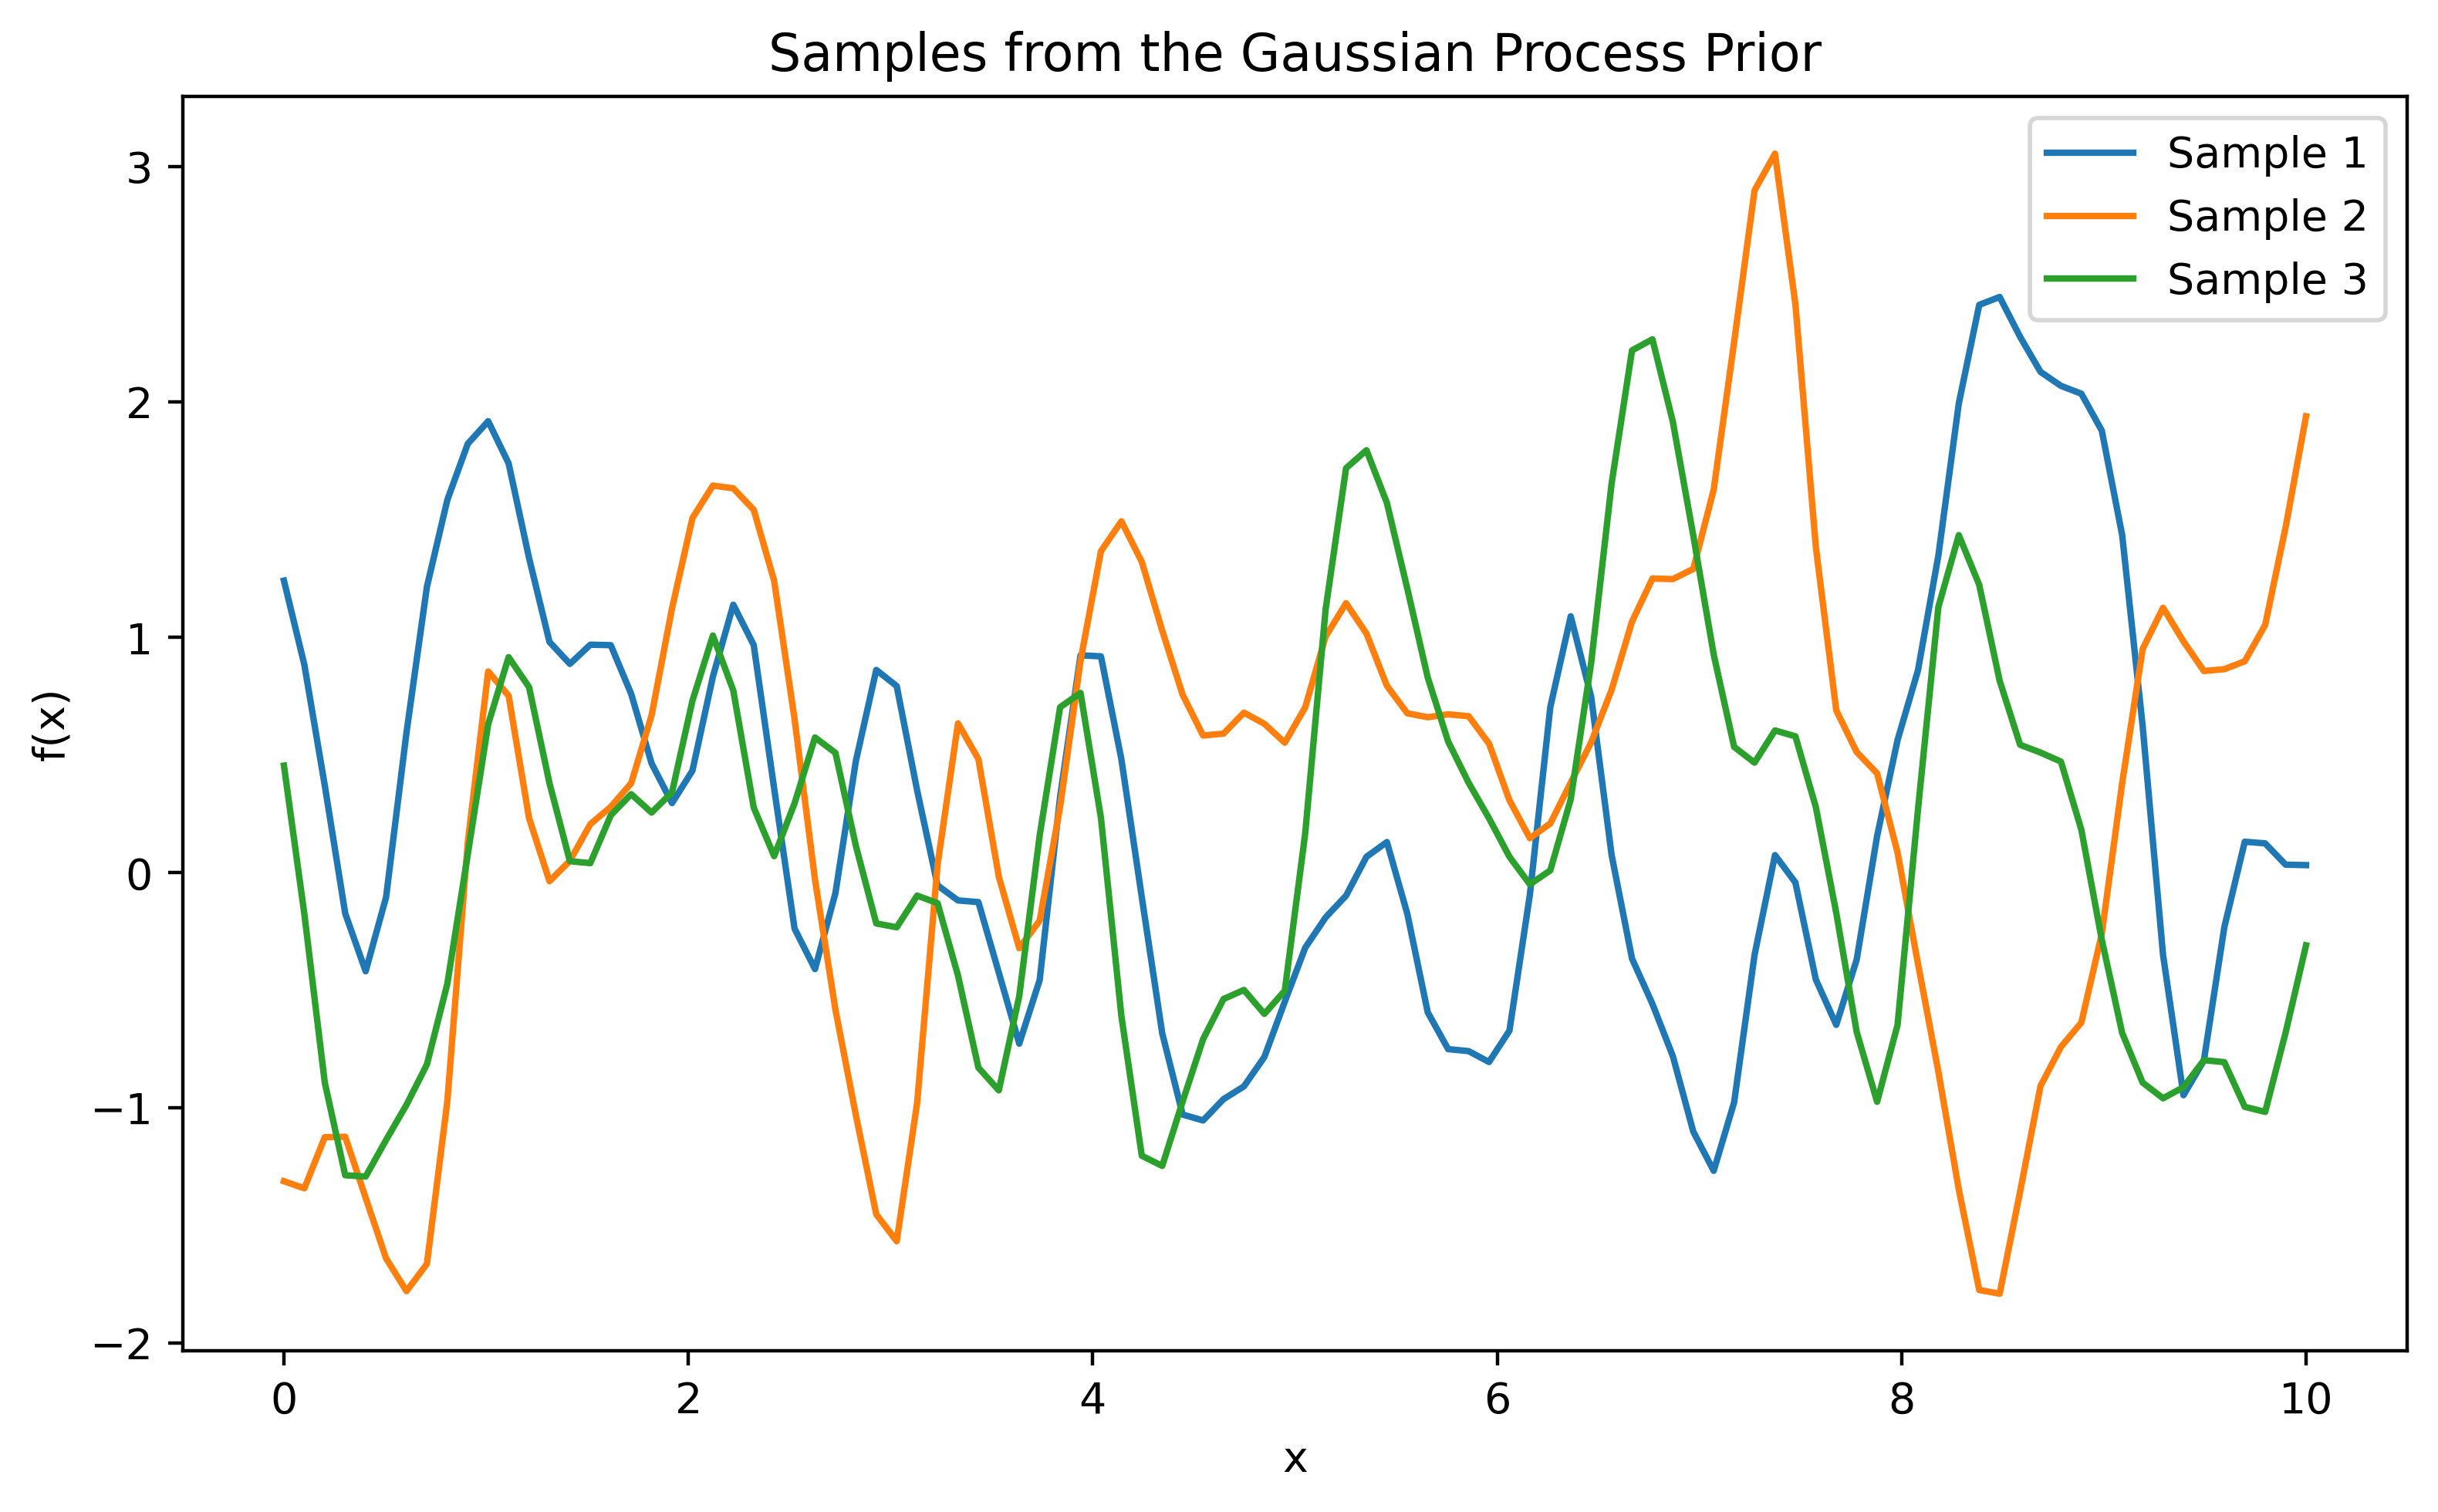

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial

# Gaussian (RBF) Kernel definition
def gaussian_kernel(X, Xprime, gamma):
    dists = scipy.spatial.distance.cdist(X, Xprime, metric='sqeuclidean')
    return np.exp(-gamma * dists)

# Generate sample points for the Gaussian Process
X = np.linspace(0, 10, 100).reshape(-1, 1)  # 100 points in the range [0, 10]
gamma = 10.0  # Kernel parameter

# Compute the kernel matrix
K = gaussian_kernel(X, X, gamma)

# Add a small noise term for numerical stability
K += 1e-6 * np.eye(len(X))

# Draw samples from the Gaussian Process prior
mean = np.zeros(len(X))  # Zero mean function
samples = np.random.multivariate_normal(mean, K, size=3)  # Draw 3 samples

# Plot the samples
plt.figure(dpi=400, figsize=(8, 5))
for i, sample in enumerate(samples):
    plt.plot(X, sample, label=f"Sample {i+1}")
plt.title("Samples from the Gaussian Process Prior")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.tight_layout()
plt.show()

optimal params: 1.1112 [1.1112 8.8889]


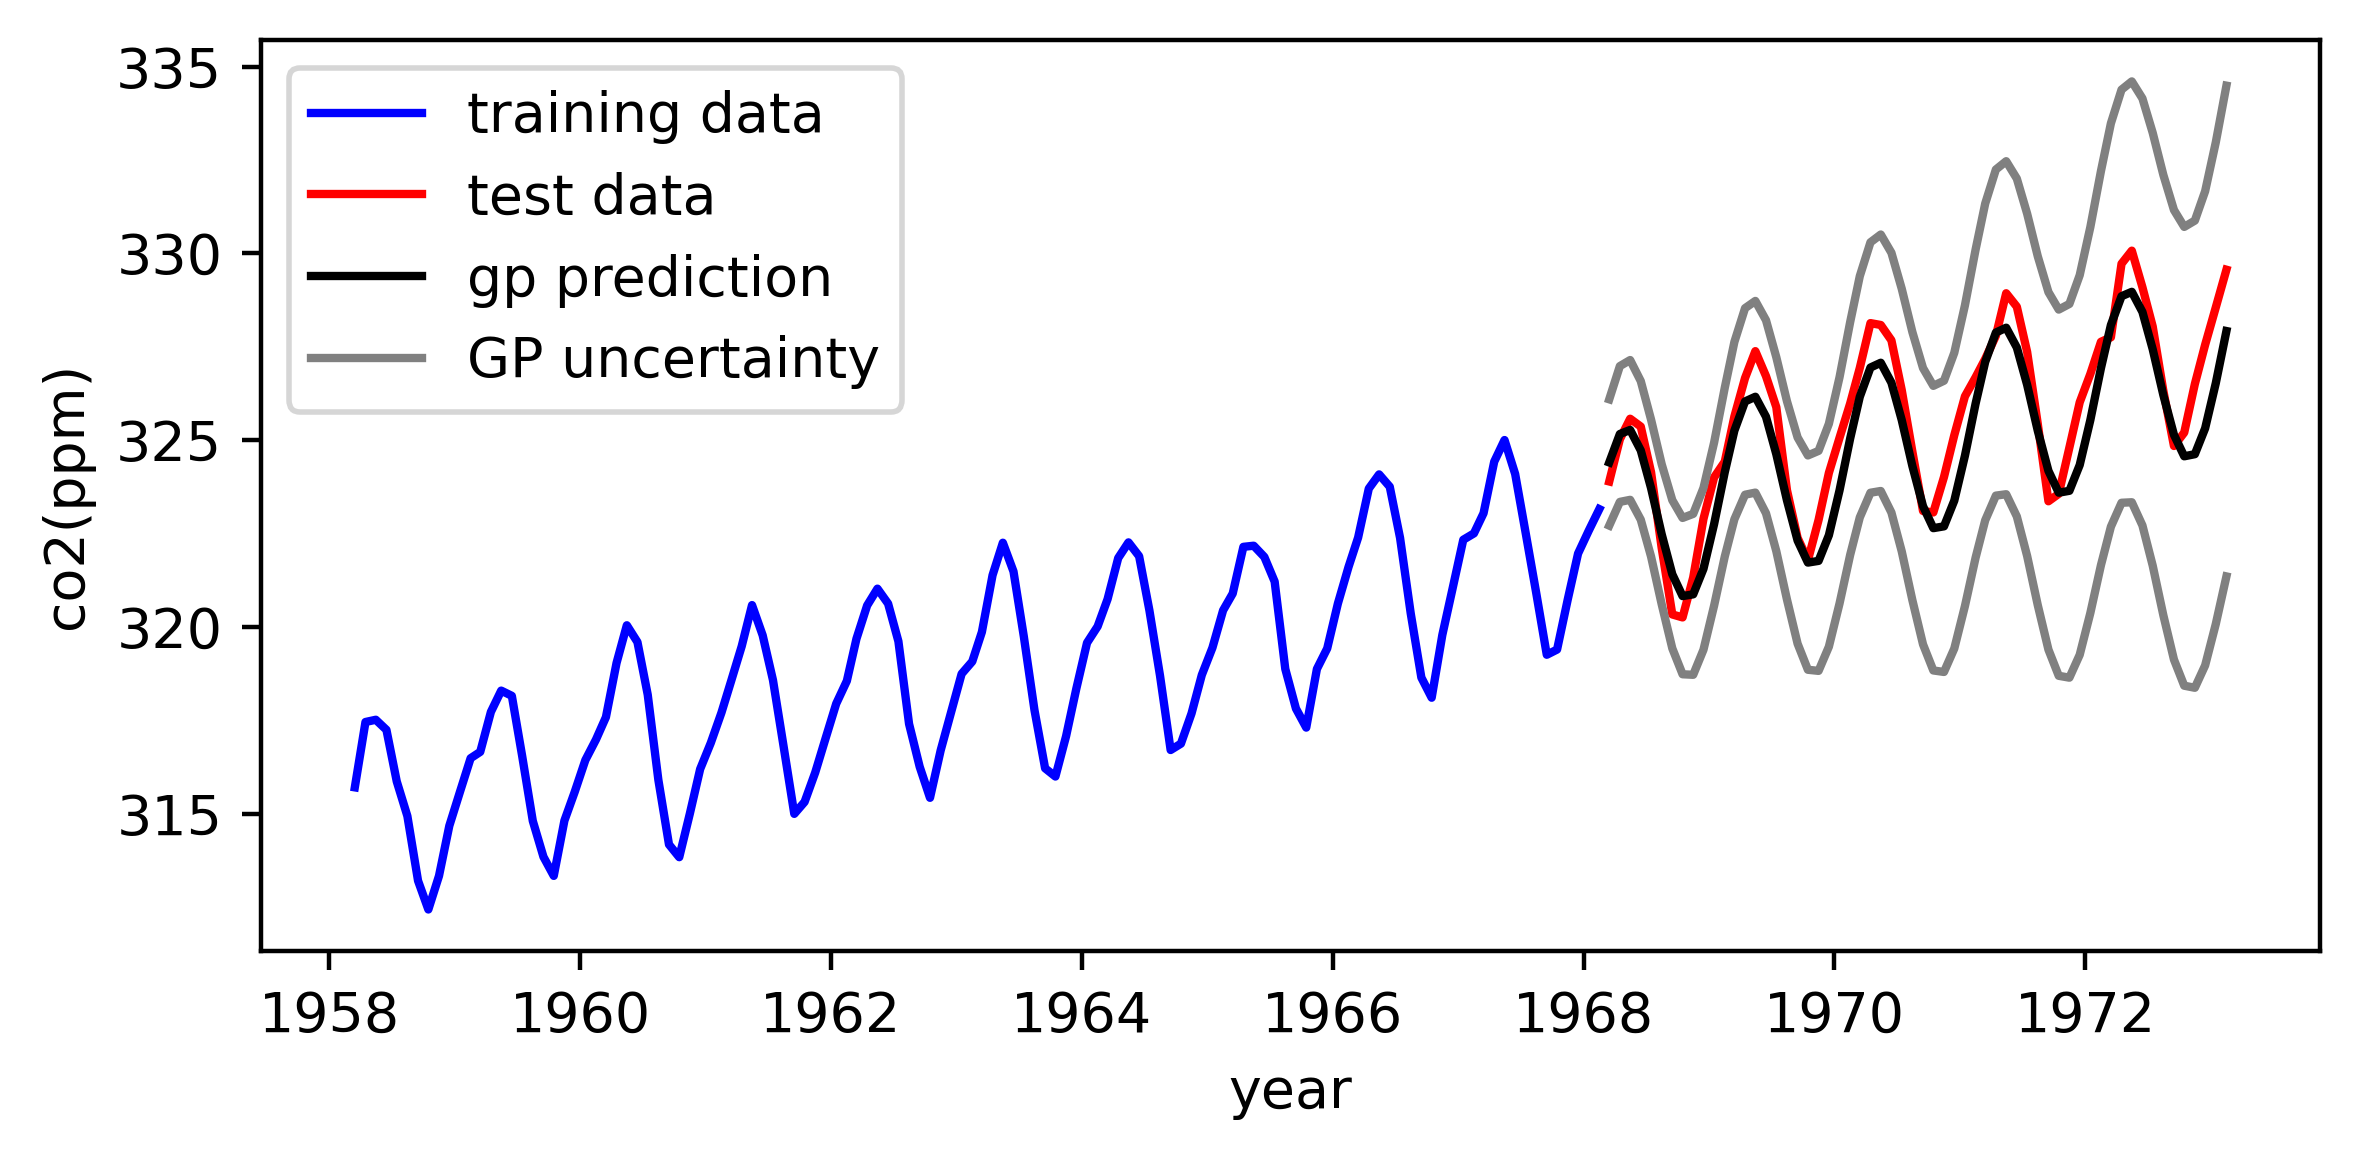

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import scipy.optimize as opt

def gaussian_kernel(X,Xprime, gamma=2):
    dists = scipy.spatial.distance.cdist(X,Xprime,metric='sqeuclidean')
    return np.exp(-gamma*dists)

def special_kernel(X,Xprime, eta):
    a = eta[0]
    b = eta[1]
    K = (1+X@Xprime.T)**2 + a * np.multiply.outer(np.sin(2*np.pi*X.reshape(-1)+b),np.sin(2*np.pi*Xprime.reshape(-1)+b))
    return K

#load and normalize Mauna Loa data 
data = np.genfromtxt('/Users/gabrielakirejczyk/Downloads/co2_mm_mlo.csv', delimiter=',')
#10 years of data for learning
X = data[:120,2]-1958
y_raw = data[:120,3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y = (y_raw-y_mean)/y_std
#the next 5 years for prediction
X_predict = data[120:180,2]-1958
y_predict = data[120:180,3]

# B) todo: implement this
def negLogLikelihood(params, kernel):
    noise_y = params[0]
    eta = params[1:]
    # todo: calculate the negative loglikelihood (See section 6.3 in the lecture notes)
        # Step 1: Compute the kernel matrix K using the kernel function
    K = kernel(X.reshape(-1, 1), X.reshape(-1, 1), eta)
    
    # Step 2: Add noise variance to the diagonal (K + sigma_y^2 I)
    K += noise_y * np.eye(len(X))
    
    # Step 3: Compute the inverse and determinant of the matrix (K + sigma_y^2 I)
    try:
        L = np.linalg.cholesky(K)  # Use Cholesky decomposition for numerical stability
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))  # Efficient way to compute (K + sigma_y^2 I)^-1 y
    except np.linalg.LinAlgError:
        # If K is not positive definite, return a large penalty
        return 1e10  # Penalize if decomposition fails
    
    # Compute log determinant using Cholesky factor (log(det(K)) = 2 * sum(log(diag(L))))
    log_det_K = 2 * np.sum(np.log(np.diag(L)))
    
    # Step 4: Calculate the negative log-likelihood
    nll = 0.5 * (y.T @ alpha) + 0.5 * log_det_K + 0.5 * len(X) * np.log(2 * np.pi)
    
    return nll
    #return 0.0 # todo: return the negative loglikelihood
    
def optimize_params(ranges, kernel, Ngrid):
    opt_params = opt.brute(lambda params: negLogLikelihood(params, kernel), ranges, Ns=Ngrid, finish=None)
    noise_var = opt_params[0]
    eta = opt_params[1:]
    return noise_var, eta

# B) todo: implement the posterior distribution, i.e. the distribution of f^star
def conditional(X, y, noise_var, eta, kernel, X_star):
    # Kernel matrix for training data
    K = kernel(X.reshape(-1, 1), X.reshape(-1, 1), eta) + noise_var * np.eye(len(X))
    # Kernel vector between training data and test points
    k_star = kernel(X.reshape(-1, 1), X_star.reshape(-1, 1), eta)
    # Kernel value for test points
    k_star_star = kernel(X_star.reshape(-1, 1), X_star.reshape(-1, 1), eta)
    # Cholesky decomposition for numerical stability
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))  # (K + sigma_y^2 I)^-1 y
    # Compute the posterior mean
    mustar = k_star.T @ alpha
    # Compute the posterior covariance
    v = np.linalg.solve(L, k_star)  # (K + sigma_y^2 I)^-1 k_star
    Sigmastar = k_star_star - v.T @ v  # k_star_star - k_star^T (K + sigma_y^2 I)^-1 k_star
    return mustar, Sigmastar


kernel = special_kernel  # Use the new kernel defined earlier
ranges = ((1.e-4, 10), (1.e-4, 10), (1.e-4, 10))  # First range for noise_var, second for eta[0], third for eta[1]

Ngrid = 10
noise_var, eta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)

# B) todo: use the learned GP to predict on the observations at X_predict
prediction_mean_gp, Sigma_gp = conditional(X, y, noise_var, eta, kernel, X_predict)
var_gp = np.diag(Sigma_gp) # We only need the diagonal term of the covariance matrix for the plots.

#plotting code for your convenience
plt.figure(dpi=400,figsize=(6,3))
plt.plot(X + 1958, y_raw, color='blue', label='training data')
plt.plot(X_predict + 1958, y_predict, color='red', label='test data')
yout_m =prediction_mean_gp*y_std + y_mean
yout_v =var_gp*y_std**2
plt.plot(X_predict + 1958, yout_m, color='black', label='gp prediction')
plt.plot(X_predict + 1958, yout_m+1.96*yout_v**0.5, color='grey', label='GP uncertainty')
plt.plot(X_predict + 1958, yout_m-1.96*yout_v**0.5, color='grey')
plt.xlabel("year")
plt.ylabel("co2(ppm)")
plt.legend()
plt.tight_layout()

## WEEK 4 - EX 1

In [4]:
import arviz


In [5]:
import pyro
import torch
import pyro.distributions as pdist
import torch.distributions as tdist
import numpy as np

In [6]:
from torch.distributions import constraints

In [7]:
# We need constraints to specify the integration interval
from torch.distributions import constraints


class MyDensity(pdist.TorchDistribution):
    # Define the interval [-3, 3]
    support = constraints.interval(-3.0, 3.0)
    
    # Constraint for the starting value
    arg_constraints = {"start": support}
    
    def __init__(self, start=torch.tensor(0.0)):
        """
        Initialize the distribution with a starting value for HMC sampling.
        
        Args:
            start (torch.Tensor): The starting value for sampling. Default is 0.0.
        """
        # Ensure the starting value lies within the specified support
        if not MyDensity.support.check(start):
            raise ValueError(f"The starting point {start} is not within the support interval [-3, 3].")
        
        self.start = start
        super().__init__(batch_shape=torch.Size())


    def sample(self, sample_shape=torch.Size()):
        # This is only used to start the HMC sampling
        # It simply returns the starting value for the sampling
        return self.start

    def log_prob(self, x):
        # Return log of the (unnormalized) density
        if not self.support.check(x).all():
            return torch.tensor(float('-inf'))  # Ensure log_prob is -inf for values outside support

        # Compute the log of the unnormalized density
        term1 = -0.5 * x.pow(2)  # -x^2 / 2
        term2 = torch.log(
            torch.sin(x).pow(2) + 
            3 * torch.cos(x).pow(2) * torch.sin(7 * x).pow(2) + 
            1
        )
        return term1 + term2

In [8]:
def model():
    # Use the MyDensity distribution
    x = pyro.sample("x", MyDensity(start=torch.tensor(0.0)))
    return x

In [13]:
from pyro.infer.mcmc import NUTS, MCMC

# Define the NUTS kernel
nuts_kernel = NUTS(model, jit_compile = True)#, adapt_step_size=True, target_accept_prob=0.8)

# Set up the MCMC object
mcmc = MCMC(
    nuts_kernel,
    num_samples=1000,       # Number of samples to draw
    warmup_steps=500,       # Number of warmup (burn-in) steps
    num_chains=2            # Use multiple chains for robust sampling
)

# Run MCMC
mcmc.run()

Warmup [1]:   0%|          | 0/1500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1500 [00:00, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/gabrielakirejczyk/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gabrielakirejczyk/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'model' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/gabrielakirejczyk/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gabrielakirejczyk/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [11]:
# Get the samples from the MCMC object
samples = mcmc.get_samples()  # Returns a dictionary of samples

# Extract the samples for the variable "x"
x_samples = samples["x"]

# Calculate E[x**2]
E_x_squared = torch.mean(x_samples**2).item()  # Square the samples, take the mean, convert to Python float

print(f"E[x^2]: {E_x_squared}")

AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
# Convert the MCMC samples to ArviZ InferenceData
data = az.from_pyro(mcmc)

# Summarize the results
summary = az.summary(data)
print(summary)

# Plot the posterior distribution and diagnostics
az.plot_trace(data)
az.plot_posterior(data, var_names=["x"])
az.plot_autocorr(data)

In [ ]:
# HMC / NUTS
def HMC(n_samples):
    # Run HMC / NUTS
    nuts_kernel = NUTS(model, jit_compile = True) #, adapt_step_size=True, target_accept_prob=0.8)  # Initialize NUTS sampler for the model
    mcmc = MCMC(nuts_kernel, num_samples=n_samples, warmup_steps=200, num_chains=2)  # Configure MCMC
    mcmc.run()  # Run the MCMC sampling
    
    # Get the samples from the MCMC object
    samples = mcmc.get_samples()["x"]  # Extract samples for variable "x"
    
    # Calculate E(x^2)
    expected_val = torch.mean(samples**2).item()  # Calculate the expected value of x^2
    return expected_val

In [ ]:
# Calculate for multiple sample sizes
sample_sizes = [10, 100, 1000]
num_repeats = 10  # Number of times each sampling process is repeated to compute statistics

means = []
std_devs = []

for n_samples in sample_sizes:
    results = []
    for _ in range(num_repeats):
        expected_val = HMC(n_samples)  # Call the HMC function to get E[x^2]
        results.append(expected_val)
    
    mean_val = np.mean(results)
    std_dev_val = np.std(results)
    means.append(mean_val)
    std_devs.append(std_dev_val)
    print(f"Sample size {n_samples}: Mean E[x^2] = {mean_val}, Std Dev = {std_dev_val}")

# Plot the means and standard deviations for each sample size
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(sample_sizes, means, marker='o')
plt.xlabel("Sample size")
plt.ylabel("Mean E[x^2]")
plt.title("Mean of E[x^2] for different sample sizes")

plt.subplot(2, 1, 2)
plt.plot(sample_sizes, std_devs, marker='o')
plt.xlabel("Sample size")
plt.ylabel("Std Dev of E[x^2]")
plt.title("Standard deviation of E[x^2] for different sample sizes")

plt.tight_layout()
plt.show()